<div style="text-align: center;"> <h3>Data Mining and Wrangling</h3>
<h5>Formative Assessment 5</h5>
<h5>Arpil 30, 2025</h5>    
<h5><u>By Romand Lansangan</u></h5>
    </div>
    
---

## Case study: Titanic Dataset

**Objective**: The objective of this assessment is to develop an understanding of logistic regression and its application in binary classification tasks. You will implement logistic regression using the Titanic dataset, analyze model performance, and interpret the results.

**Dataset**:
For this assignment, you will use the Titanic dataset, which contains passenger information and their survival status. You can download the dataset from the following sources:

Kaggle: https://www.kaggle.com/c/titanic/data

Seaborn’s built-in dataset (sns.load_dataset('titanic') in Python)


### 1.1 Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df =  sns.load_dataset("titanic")
print("Shape:", f"{df.shape[0]} X {df.shape[1]}")
df.head()

Shape: 891 X 15


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB



The dataset includes the following key features:

* pclass: Passenger class (1st, 2nd, 3rd)

* sex: Gender of the passenger

* age: Age of the passenger

* sibSp: Number of siblings/spouses aboard

* parch: Number of parents/children aboard

* fare: Ticket fare

* embarked: Port of embarkation

* survived: Target variable (0 = No, 1 = Yes)

and some unnecessary columns. More on that later.

### Split

To prevent data leakage, let us split the data first into training and testing batches.

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)

Shape of df_train: (712, 15)
Shape of df_test: (179, 15)


### EDA

#### Cardinality

In [5]:
df_train.nunique()

survived         2
pclass           3
sex              2
age             83
sibsp            7
parch            7
fare           220
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

As we can see, most of these are categorical data. `fare` and `age` are the only continous variables.

In [6]:
df_train.embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [7]:
df_train.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', nan], dtype=object)

In [8]:
del df_train['embarked']

In [9]:
df_train.alive.unique()

array(['no', 'yes'], dtype=object)

In [10]:
df_train.survived.unique()

array([0, 1], dtype=int64)

In [11]:
mask = ((df_train['alive'] == 'no') & (df_train['survived'] == 0)) | ((df_train['alive'] == 'yes') & (df_train['survived'] == 1))
len(df_train) - mask.sum()

0

`alive` and `survive` are exactly the same.

In [12]:
del df_train['alive']

#### Missing Data

In [13]:
df_train.isna().sum() * 100 / len(df_train)

survived        0.000000
pclass          0.000000
sex             0.000000
age            19.662921
sibsp           0.000000
parch           0.000000
fare            0.000000
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.808989
embark_town     0.280899
alone           0.000000
dtype: float64

For the missing values in `age` we can just impute the average age.

For the missing values in `embark_town`, we can impute the majority class.

For the deck however, this much more complicated.

In [14]:
df_train.deck.unique()

['C', NaN, 'B', 'F', 'D', 'E', 'A', 'G']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [15]:
df_train_copy = df_train.copy()

df_train_copy['deck'] = df_train_copy['deck'].astype("object").fillna("None")

In [16]:
df_train_copy.groupby(["deck", 'pclass']).count()['sex']

deck  pclass
A     1          10
B     1          38
C     1          52
D     1          17
      2           2
E     1          18
      2           3
      3           3
F     2           7
      3           5
G     3           3
None  1          28
      2         139
      3         387
Name: sex, dtype: int64

Maybe these are the people who are not assigned any particular deck or cabin.

We can make it into it's own category.

#### Imputation

Age is a bit complicated. Usually, we can just fill the missing values with the mean. However, this will increase the kurtosis to a significant degree. We don't want that. So I'm thinking of creating a random normal distribution with the mean and std of the `Age` as its parameter. First off, let's look at the distribution of `Age`. 

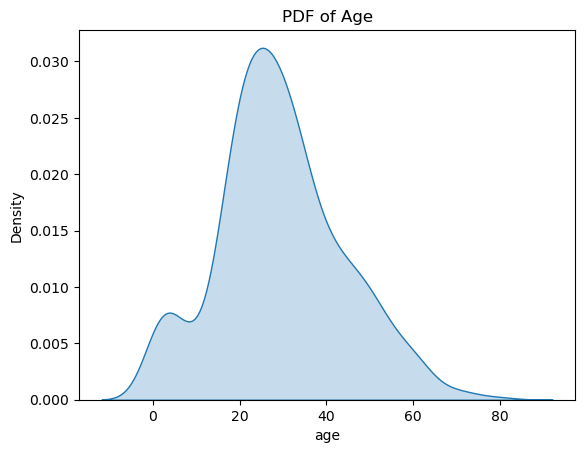

In [17]:
sns.kdeplot(df_train['age'], fill=True)
plt.title("PDF of Age");

Age is normally distributed which means, we can proceed with our random normal distribution imputation.

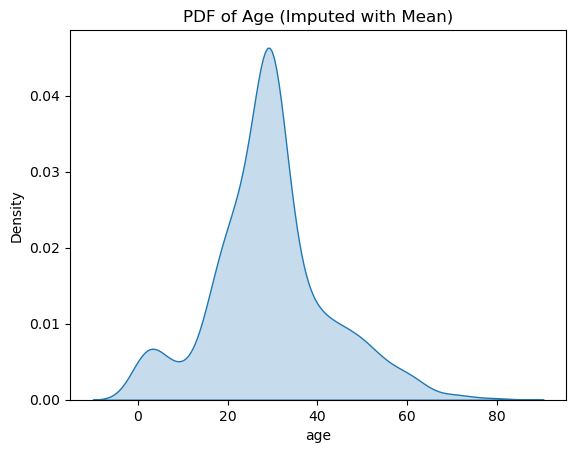

In [18]:
mean_age = df_train['age'].mean()
mean_imputed = df_train['age'].fillna(mean_age)
sns.kdeplot(mean_imputed, fill=True)
plt.title("PDF of Age (Imputed with Mean)");

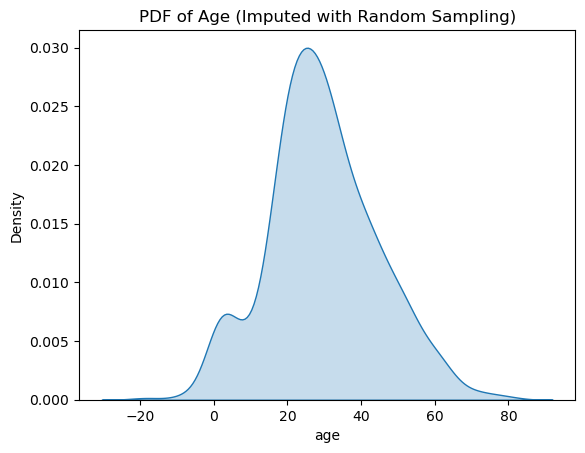

In [19]:
mask = df_train['age'].isna()
na_index = df_train.loc[mask, 'age'].index

random_age = np.random.normal(mean_age, df_train['age'].std(), len(na_index))
df_train.loc[na_index, 'age'] = random_age

sns.kdeplot(df_train['age'], fill=True)
plt.title("PDF of Age (Imputed with Random Sampling)");

For `embark_town`, we could just impute the majority class.

In [20]:
majority_class = df_train['embark_town'].value_counts(ascending=False).index[0]
df_train['embark_town'] = df_train['embark_town'].fillna(majority_class)

For `deck` let's create new category called "None"

In [21]:
df_train['deck'] = df_train['deck'].astype("object").fillna("None")

In [22]:
df_train.isna().sum() * 100 / len(df_train)

survived       0.0
pclass         0.0
sex            0.0
age            0.0
sibsp          0.0
parch          0.0
fare           0.0
class          0.0
who            0.0
adult_male     0.0
deck           0.0
embark_town    0.0
alone          0.0
dtype: float64

### Distribution

In [ ]:
df_train.groupby(col, "survived").count()

,pclass,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alone,IsMale
survived,,,,,,,,,,,,
0,444,444,444,444,444,444,444,444,444,444,444,444
1,268,268,268,268,268,268,268,268,268,268,268,268


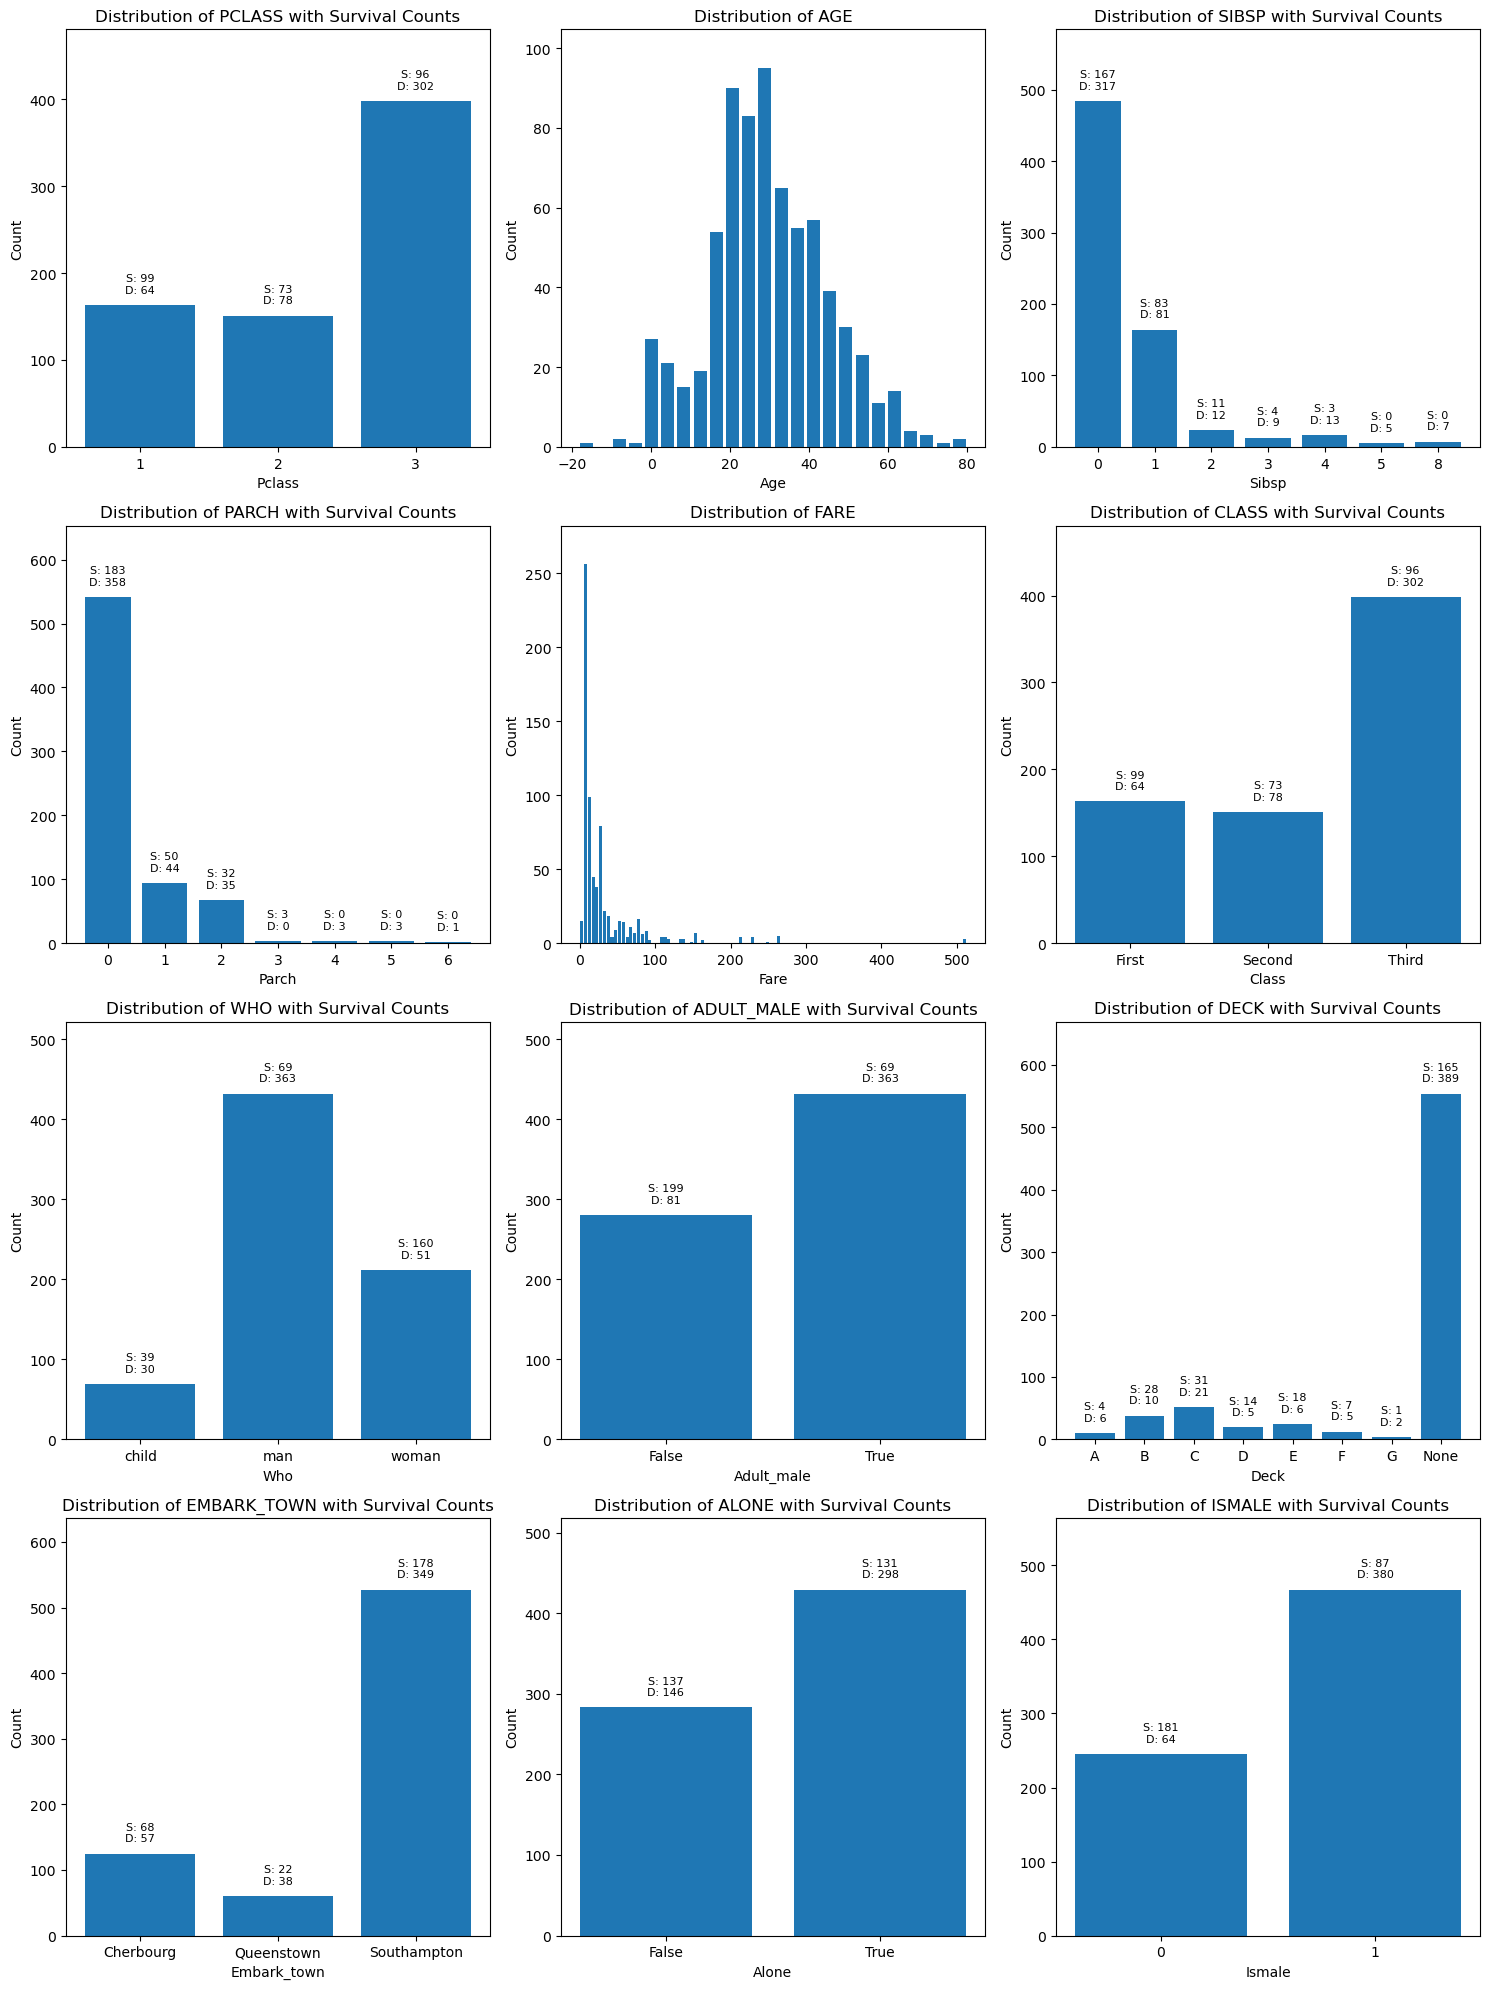

In [50]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

cols_to_plot = [col for col in df_train.columns.to_list() if col != 'survived']

rows = int(np.ceil(len(cols_to_plot) / 3))

if rows == 0:
    print("No columns found in df_train to plot other than 'survived'.")
    exit() 

fig, axes = plt.subplots(ncols=3, nrows=rows, figsize=(15, 5*rows))

if axes.ndim == 0: 
    axes = np.array([axes])
elif axes.ndim == 1:
    pass 
else: 
    axes = axes.flatten()


cols_to_plot = cols_to_plot[:len(axes)]

for ind, col in enumerate(cols_to_plot):
    ax = axes[ind]

    is_discrete = df_train[col].nunique() <= 10 or pd.api.types.is_categorical_dtype(df_train[col]) or pd.api.types.is_bool_dtype(df_train[col])

    if is_discrete:
        counts = df_train.groupby([col, 'survived'], dropna=False).size().unstack(fill_value=0)
        total_counts = counts.sum(axis=1)

        if total_counts.empty:
             print(f"Column '{col}' has no data to plot.")
             ax.set_title(f"No data for {col.upper()}")
             ax.set_xlabel(col.capitalize())
             ax.set_ylabel("Count")
             continue


        x_values = counts.index

        bars = ax.bar(x_values.astype(str), total_counts.values)
        ax.set_xticks(x_values.astype(str)) 

        max_height = total_counts.max()
        offset = max_height * 0.03 

        for bar, (x_val, total), (died, survived) in zip(bars, total_counts.items(), counts.values):
             bar_x_pos = bar.get_x() + bar.get_width() / 2
             text = f"S: {survived}\nD: {died}"
             ax.text(bar_x_pos, total + offset, text, ha='center', va='bottom', fontsize=8)

    else:
        data_to_bin = df_train[col].dropna()
        if data_to_bin.empty:
             print(f"Column '{col}' has no non-NaN values to plot.")
             ax.set_title(f"No data for {col.upper()}")
             ax.set_xlabel(col.capitalize())
             ax.set_ylabel("Count")
             continue 

        _, edges = np.histogram(data_to_bin, bins='auto') 

        df_temp = df_train[[col, 'survived']].dropna() 
        if df_temp.empty: 
             print(f"Column '{col}' has no data with corresponding 'survived' status.")
             ax.set_title(f"No data for {col.upper()}")
             ax.set_xlabel(col.capitalize())
             ax.set_ylabel("Count")
             continue

        df_temp['temp_bin'] = pd.cut(df_temp[col], bins=edges, include_lowest=True)

        bin_counts = df_temp.groupby(['temp_bin', 'survived'], observed=False).size().unstack(fill_value=0)

        bin_counts['total'] = bin_counts.sum(axis=1)

        bin_intervals = bin_counts.index
        bin_centers = np.array([(interval.left + interval.right) / 2 for interval in bin_intervals])

        bar_width = np.mean(np.diff(edges)) * 0.8 if len(edges) > 1 else 1 # Use 80% of bin width

        ax.bar(bin_centers, bin_counts['total'], width=bar_width)



    ax.set_title(f"Distribution of {col.upper()}" + (" with Survival Counts" if is_discrete else "")) 
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel("Count")

    ax.set_ylim(0, ax.get_ylim()[1] * (1.15 if is_discrete else 1.05))

for i in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout() 
plt.show()

### Data type


In [24]:
df_train.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
class          category
who              object
adult_male         bool
deck             object
embark_town      object
alone              bool
dtype: object

#### Sex
Let's turn `Sex` to `IsMale` where 1 is male and 0 is not.

In [25]:
df_train['IsMale'] = (df_train['sex'] == "male").astype(int)

In [26]:
del df_train['sex']

#### Who


In [27]:
df['who'].unique()

array(['man', 'woman', 'child'], dtype=object)

Let's use one hot encoding.

In [28]:
df_train_encoded = pd.concat([pd.get_dummies(df_train["who"], dtype="int"), df_train.drop(columns=["who"])], axis=1)
df_train_encoded.head()

,child,man,woman,survived,pclass,age,sibsp,parch,fare,class,adult_male,deck,embark_town,alone,IsMale
331,0,1,0,0,1,45.5,0,0,28.5000,First,True,C,Southampton,True,1
733,0,1,0,0,2,23.0,0,0,13.0000,Second,True,None,Southampton,True,1
382,0,1,0,0,3,32.0,0,0,7.9250,Third,True,None,Southampton,True,1
704,0,1,0,0,3,26.0,1,0,7.8542,Third,True,None,Southampton,False,1
813,1,0,0,0,3,6.0,4,2,31.2750,Third,False,None,Southampton,False,0


In [29]:
pd.get_dummies(df_train["who"])

,child,man,woman
331,False,True,False
733,False,True,False
382,False,True,False
704,False,True,False
813,True,False,False
...,...,...,...
106,False,False,True
270,False,True,False
860,False,True,False
435,True,False,False


#### Embark_town

In [30]:
cats = ["who", "embark_town"]
df_train_encoded = pd.concat([df_train.drop(columns=cats), pd.get_dummies(df_train[cats], dtype="int")], axis=1)
print(df_train_encoded.shape)
df_train_encoded.head()

(712, 17)


,survived,pclass,age,sibsp,parch,fare,class,adult_male,deck,alone,IsMale,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
331,0,1,45.5,0,0,28.5000,First,True,C,True,1,0,1,0,0,0,1
733,0,2,23.0,0,0,13.0000,Second,True,None,True,1,0,1,0,0,0,1
382,0,3,32.0,0,0,7.9250,Third,True,None,True,1,0,1,0,0,0,1
704,0,3,26.0,1,0,7.8542,Third,True,None,False,1,0,1,0,0,0,1
813,0,3,6.0,4,2,31.2750,Third,False,None,False,0,1,0,0,0,0,1


In [31]:
df_train_encoded.dtypes

survived                      int64
pclass                        int64
age                         float64
sibsp                         int64
parch                         int64
fare                        float64
class                      category
adult_male                     bool
deck                         object
alone                          bool
IsMale                        int32
who_child                     int32
who_man                       int32
who_woman                     int32
embark_town_Cherbourg         int32
embark_town_Queenstown        int32
embark_town_Southampton       int32
dtype: object

#### Addressing Man and Male

So we have a problem. We have a column named `IsMale` but we also have a one hot encoded for `who_male`. But these are not equal because a person can be a male, and in `who_child`. This is the name for children of female gender.

In [32]:
df_train_encoded['who_man'].corr(df_train_encoded['IsMale'])

0.8996787435200131

In [33]:
df_train_encoded['who_woman'].corr(df_train_encoded['IsMale'])

-0.895978859814736

In linear regression, we can't have multicollinearity.

We can create new feature instead:
`adult` 

In [34]:
df_train_clean = df_train_encoded.copy()
df_train_clean['adult'] = df_train_encoded['who_man'] | df_train_encoded['who_woman']
df_train_clean.drop(columns=['who_man', 'who_woman', 'adult_male', 'who_child'], inplace=True)
df_train_clean.columns

Index(['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'class', 'deck',
       'alone', 'IsMale', 'embark_town_Cherbourg', 'embark_town_Queenstown',
       'embark_town_Southampton', 'adult'],
      dtype='object')

#### Class and Deck

`class` and `deck` could label encoded because they have inherent order.

In [35]:
mapping_deck = {
    "None": 0,
    "G": 1,
    "F": 2,
    "E": 3,
    "D": 4,
    "C": 5,
    "B": 6,
    "A": 7
}

df_train_clean['deck'] = df_train_clean['deck'].map(mapping_deck).astype(int)

In [36]:
mapping_class ={
    "First": 1,
    "Second": 2,
    "Third": 3
}
df_train_clean['class'] = df_train_clean['class'].map(mapping_class).astype(int)

In [37]:
del df_train_clean['pclass']

### Correlation

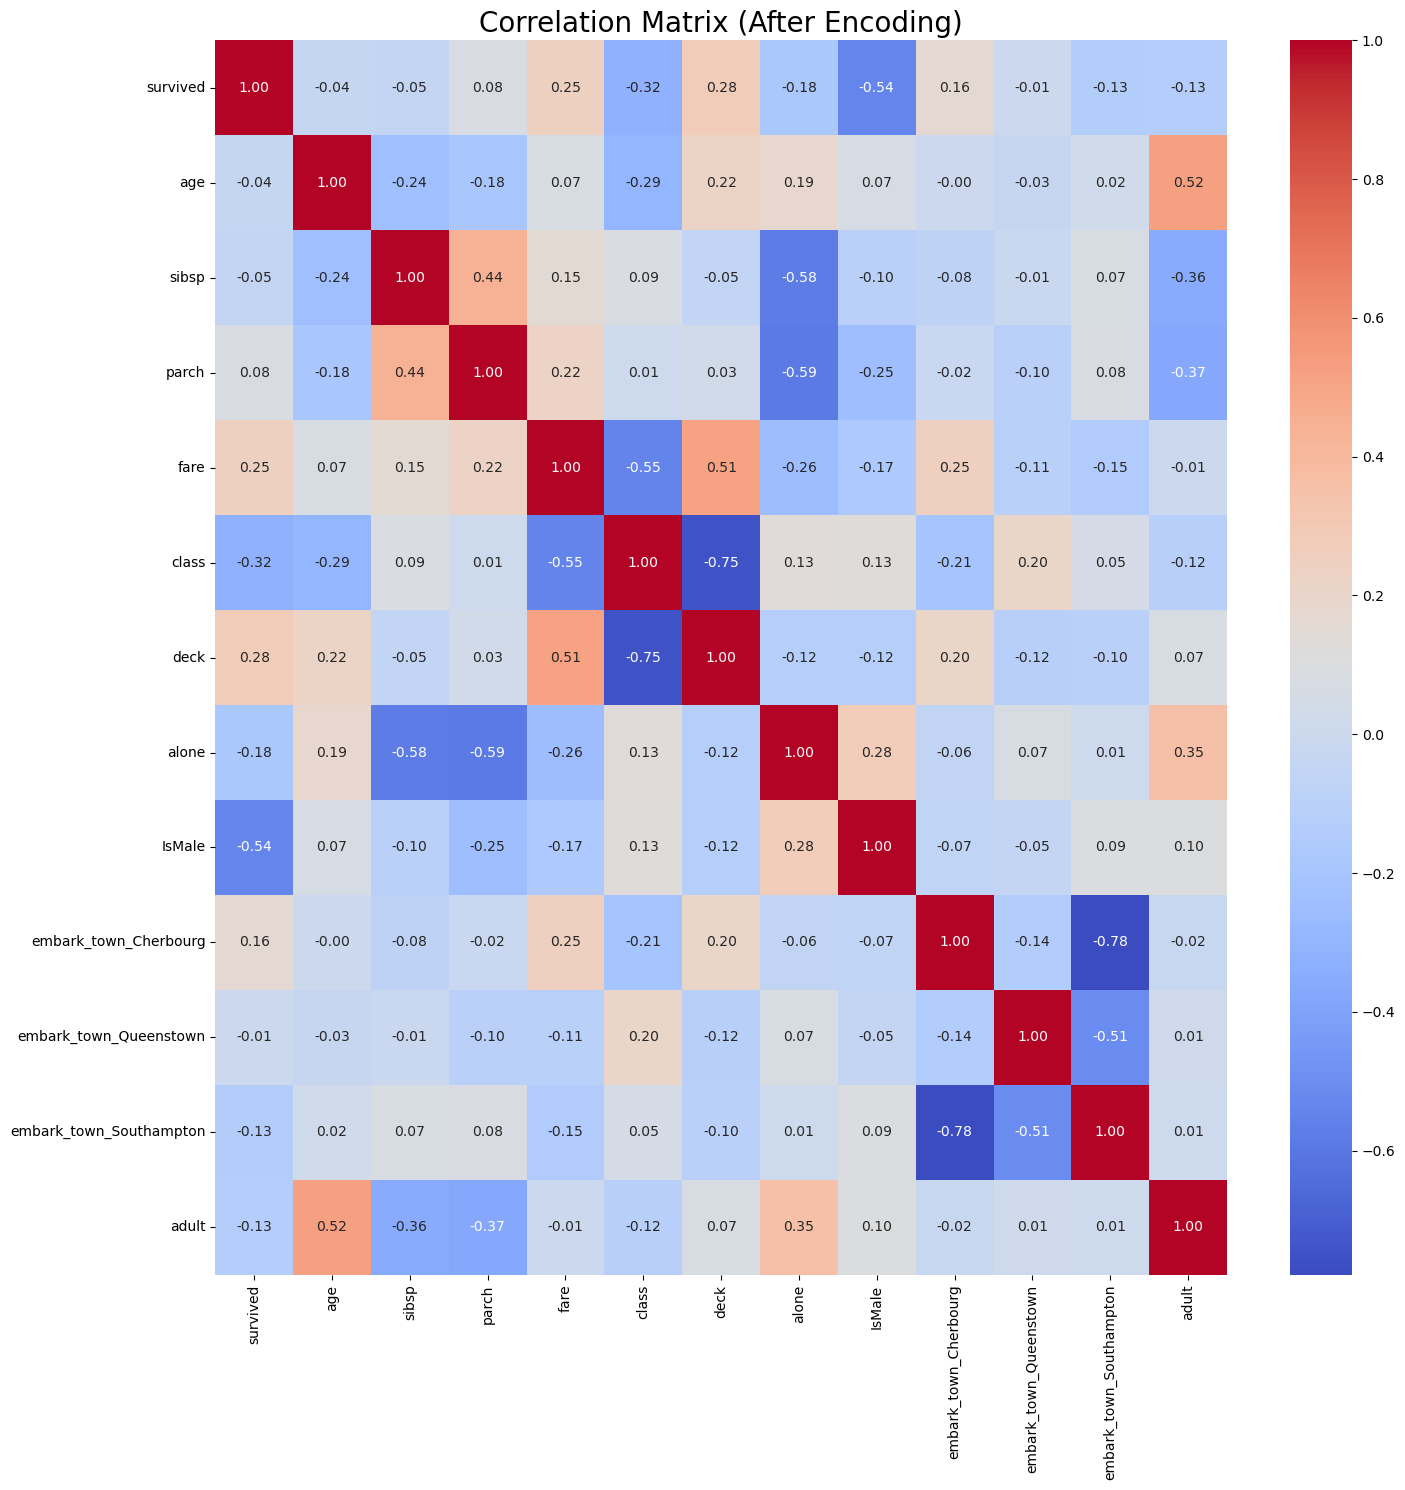

In [38]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train_clean.corr(), annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Correlation Matrix (After Encoding)", size=20)
plt.tight_layout()
plt.show();

### Patterns

In [ ]:
for col in df_train_clean.drop(columns="survived").columns:
    sns.scatterplot(x=df_train_clean[col], y=df['survived'])

NameError: name 'asda' is not defined

---

## Baseline

In [ ]:
df_train_clean['survived'].value_counts(normalize=True)

survived
0    0.623596
1    0.376404
Name: proportion, dtype: float64

In [ ]:
baseline = df_train_clean['survived'].value_counts(normalize=True).sort_values(ascending=False)
print("Baseline Class Distribution:", baseline )
print("\nBaseline Accuracy:", baseline[0])

Baseline Class Distribution: survived
0    0.623596
1    0.376404
Name: proportion, dtype: float64

Baseline Accuracy: 0.6235955056179775


---
## Model Implementation

In [ ]:
X = df_train_clean.drop(columns=["survived"])
y = df_train_clean["survived"]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = [
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__solver': ['liblinear', 'saga'],
        'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'logreg__class_weight': [None, 'balanced']
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__solver': ['saga'],
        'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'logreg__l1_ratio': [0.5],
        'logreg__class_weight': [None, 'balanced']
    }
]

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy', 
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'logreg__class_weight': [None, 'balanced'],
                          'logreg__penalty': ['l1', 'l2'],
                          'logreg__solver': ['liblinear', 'saga']},
                         {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'logreg__class_weight': [None, 'balanced'],
                          'logreg__l1_ratio': [0.5],
                          'logreg__penalty': ['elasticnet'],
                          'logreg__solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [ ]:
grid_search.best_params_

{'logreg__C': 10,
 'logreg__class_weight': None,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear'}

In [ ]:
model = grid_search.best_estimator_

---

## Model Evaluation

### Training Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

print("Train Accucary:", accuracy_score(y, model.predict(X)))

Train Accucary: 0.8146067415730337


### Test Accuracy

In [ ]:
df_test_copy = df_test.copy()

df_test_copy['deck'] = df_test_copy['deck'].astype("object").fillna("None")

mask = df_test_copy['age'].isna()
na_index = df_test_copy.loc[mask, 'age'].index

random_age = np.random.normal(df_test_copy['age'].mean(), df_test_copy['age'].std(), len(na_index))
df_test_copy.loc[na_index, 'age'] = random_age
df_test_copy['deck'] = df_test_copy['deck'].astype("object").fillna("None")

majority_class = df_test_copy['embark_town'].value_counts(ascending=False).index[0]
df_test_copy['embark_town'] = df_test_copy['embark_town'].fillna(majority_class)

df_test_copy['IsMale'] = (df_test_copy['sex'] == "male").astype(int)

cats = ["who", "embark_town"]
df_test_copy = pd.concat([df_test_copy.drop(columns=cats), pd.get_dummies(df_test_copy[cats], dtype="int")], axis=1)

df_test_copy['adult'] = df_test_copy['who_man'] | df_test_copy['who_woman']

mapping_deck = {
    "None": 0,
    "G": 1,
    "F": 2,
    "E": 3,
    "D": 4,
    "C": 5,
    "B": 6,
    "A": 7
}

df_test_copy['deck'] = df_test_copy['deck'].map(mapping_deck).astype(int)

mapping_class ={
    "First": 1,
    "Second": 2,
    "Third": 3
}
df_test_copy['class'] = df_test_copy['class'].map(mapping_class).astype(int)

df_test_copy.drop(columns=['who_man', 'who_woman', 'adult_male', 'who_child', 'pclass', 'sex', 'embarked', 'alive'], inplace=True)

In [ ]:
X_test = df_test_copy.drop(columns=["survived"])
y_test = df_test_copy["survived"]

print("Test Accuracy:", accuracy_score(y_test, model.predict(X_test)))

Test Accuracy: 0.8044692737430168


The gridsearch conducted brought forth the following best parameters:
{'logreg__C': 10,
 'logreg__class_weight': None,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear'}

The logistic regression model we have created produce the following results:
* Train Accuracy = 0.8146067415730337
* Test Accuracy = 0.8044692737430168

This is a remarkable score give the baseline of 0.6235955056179775. 

The test accuracy implies that if another titanic were to happen, the model will accurately predict the status of the people and 80.45% of the time, it will be right.


This also means overfitting or underfitting did not occur. This implies that the model is generalizing well in the unseen data.

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



A precision score of 0.77 on label 1 indicates that 77% of those who was labeled by the model as 1 (or those who survived) actually survived or was labeled correctly.

A recall score of 0.74 on label 1 indicates that among those who have survived, 74% were labeled correctly by our model.

An f1 score of 0.76 however is the balance with the two aforementioned metrics.

Accuracy indicates the overall performance of the model. But in some cases, accuracy can be sacrificed depending on the objectives. For example, if we were to prepare for the a cruise ship like titanic and we want to identify even tiniest bit of possibility that they will not survive in case another iceberg accident happen, we would prioritize recall because we essentially want to minimize the death toll as much as we can. However, if the cost of the intervening/preparation is massive and we have budget contraints, we ought to prioritize precision because we want to be as right as we can be. We want to make sure that those who will receive assistance will be the ones who really need it. But if we can't decide between the two metrics, we can settle with f1-score which is a good balance between the two.

### Confusion Matrix


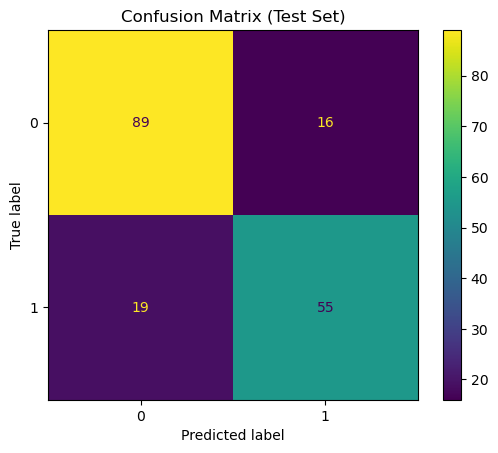

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,model.predict(X_test))
plt.title("Confusion Matrix (Test Set)");

The confusion matrix gives as a clear indication of how many were labeled correctly in the test set. According to the plot, 89 and 55 were labeled correctly with 0 and 1, respectively. The model predicted that 19 will not survive when in fact they have survived while 16 were predicted to survive when they have died. 

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

y_probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.3f}")

AUC Score: 0.876


With **AUC Score of 0.876**, our model is performing significantly better than random guessing who will surive and who will not.

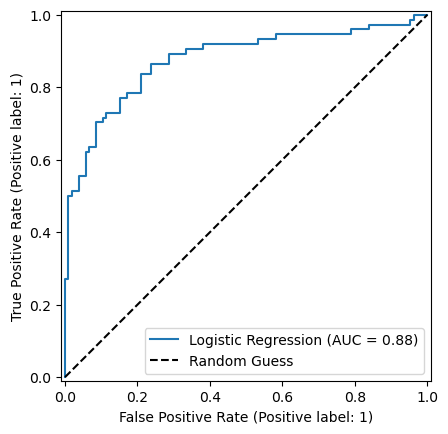

In [ ]:
RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, 
    X_test, 
    y_test,
    name='Logistic Regression'
)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.legend()
plt.show()

 The `ROC Curve`  demonstrates that the model is a reasonably effective classifier for predicting survival. Its ROC curve is well above the random guess line, and the AUC of 0.88 indicates a strong discriminatory power between passengers who survived and those who did not. This suggests that the features used by the model contain valuable information for predicting survival outcomes on the Titanic.

In [ ]:
model.named_steps

{'scaler': StandardScaler(),
 'logreg': LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear')}

In [ ]:
coefs = pd.Series(model.named_steps['logreg'].coef_[0], index=model.feature_names_in_)
coefs.iloc[np.argsort(abs(coefs))[::-1]]

IsMale                    -1.293950
sibsp                     -0.711052
class                     -0.606627
adult                     -0.481580
alone                     -0.346064
parch                     -0.313144
fare                       0.136443
age                       -0.135418
deck                       0.134113
embark_town_Southampton   -0.108749
embark_town_Cherbourg      0.024746
embark_town_Queenstown     0.000000
dtype: float64

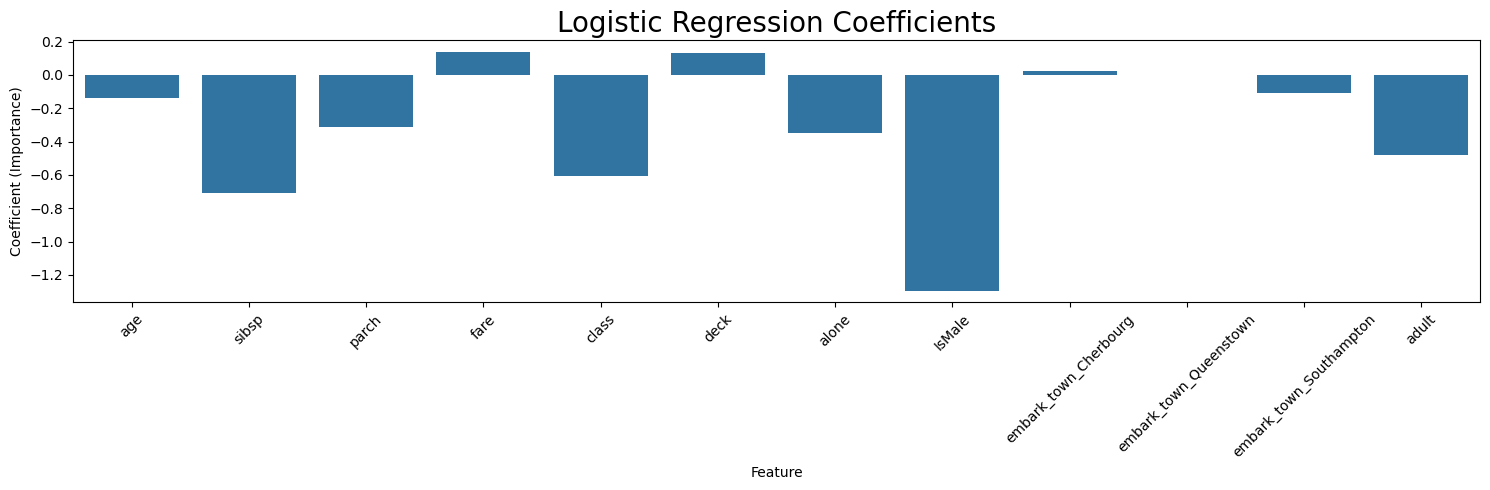

In [ ]:
plt.figure(figsize=(15, 5))

sns.barplot(x=coefs.index, y=coefs.values)

plt.title("Logistic Regression Coefficients", size=20)
plt.xticks(rotation=45)
plt.ylabel("Coefficient (Importance)")
plt.xlabel("Feature")
plt.tight_layout();

`Logistic Regression Coefficint` plot represent the comparison between each features of the titanic dataset and their importance in the final model.

The most important by far is the `IsMale` column with -1.293950 coeffcient. As it turns out being a male in the titanic ship makes you more likely to NOT surivev the crash. This could be due to the prioritization to children and women in terms of safety. This is promugated by the fact that `adult` also has a coefficient (-0.481580) which is also one of the most impactful indicator of survival. Next to `IsMale` are the `class` and `sibsp`, whichhave -0.606627 and  -0.711052 coefficients, respectively. Class is a given because the lower class (3) is less likely to be prioritized than higher ones (1 and 2). `SIBSP` is a surpising one because as it turns out, the less siblings/spouses abourd you have, the more likely you are to die. This might indicate that people who know each other might help each other during the accident which increases their likeliness to survive.

In conclusion, we have created pretty robust model using Logistic Regression and have identified the key metrics (and the possible reasons) to determine which are more likely to die in the Titanic incident. 

### Recommendation
Although the model is pretty robust, I think the model could be improved further:

* Class imbalance - a  68:32 ratio between surviving and non surviving class is a moderate one that doesn't require strict technique to balance the distribution, it might be worth looking into it and compare the results.
* Feature Engineering - we could also add other features like clustering them based on their fare and class (wheather they paid well below their class or well above their class or just right) and all that to somehow increase the predictive power of some of the features. However, since we are only using Logistic Regression, this might also just be a futile endevours.
* Modeling Technique - with that being said, we can change our modeling technique to include the non linear relationship between predictors and response. We could resort to Random Forest or even to Neural Network.
